In [1]:
import os
import glob
from pyspark.sql import SparkSession

# Caminho da pasta de saída
output_folder = "../Scripts/output"

# Obter lista de arquivos CSV de blocos
block_files = glob.glob(os.path.join(output_folder, "block", "*.csv"))

# Obter lista de arquivos CSV de swaps
swap_files = glob.glob(os.path.join(output_folder, "swap", "*.csv"))

# Obter lista de arquivos CSV de transações
transaction_files = glob.glob(os.path.join(output_folder, "transaction", "*.csv"))

In [2]:
# Criar sessão Spark

import os
import sys

output_folder = "../Scripts/output"

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .appName("Análise de Transações Ethereum") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [3]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_block_df = None

file_path = "../Scripts/output/block/block.csv"

# Ler o arquivo CSV
combined_block_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
combined_block_df.show()

+--------+--------------------+--------------------+----------+--------------------+------+---------+--------+---------------+-------------------+
|Block_ID|          Hash_Block|               Miner|Difficulty|    Total_Difficulty|  Size|Gas_Limit|Gas_Used|Timestamp_Block|Number_Transactions|
+--------+--------------------+--------------------+----------+--------------------+------+---------+--------+---------------+-------------------+
|17654749|0xcd07cb7175dbb9b...|0x388C818CA8B9251...|         0|58750003716598352...|327143| 30000000|25229766|     1688888687|                244|
|17654750|0x0858c82cf11d138...|0x1f9090aaE28b8a3...|         0|58750003716598352...|167572| 30000000|15251119|     1688888699|                133|
|17654751|0xb067e06a5265c2f...|0xDAFEA492D9c6733...|         0|58750003716598352...| 60917| 30000000|14639154|     1688888711|                175|
|17654752|0x1ddf0e5f1fba923...|0x690B9A9E9aa1C9d...|         0|58750003716598352...|164921| 30000000|19829873|     168

In [5]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_swap_df = None

file_path = "../Scripts/output/swap/swap_transactions.csv"

# Ler o arquivo CSV
combined_swap_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [6]:
combined_swap_df.show()

+--------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------------+---------------+------------------------+----------------------+-------------------+-------------------+--------------------+
|Block_ID|    Type_Transaction|    Amount_Out_Min|          Amount_Out|           Amount_In|  From_Token_Address|    To_Token_Address|From_Token_Symbol|To_Token_Symbol|From_Token_Holders_Count|To_Token_Holders_Count|   From_Token_Price|     To_Token_Price|    Hash_Transaction|
+--------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------------+---------------+------------------------+----------------------+-------------------+-------------------+--------------------+
|17654749|swapExactTokensFo...| 33800288878779616|   80641014723769807|     495000000000000|0x7e8eE59BcFb61a2...|0xC02aaA39b223FE8...|          PEPECAT|           WET

In [7]:
combined_transaction_df = None

file_path = "../Scripts/output/transaction/transactions.csv"

# Ler o arquivo CSV
combined_transaction_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [8]:
combined_transaction_df.show()

+--------+--------------------+--------------------+--------------------+------------------+-----------+---------+--------+---------+---------------------+
|Block_ID|    Hash_Transaction|                From|                  To|       Value_(Wei)|  Gas_Price|Gas_Limit|Gas_Used|   Status|Timestamp_Transaction|
+--------+--------------------+--------------------+--------------------+------------------+-----------+---------+--------+---------+---------------------+
|17654749|0x72ba0bf9cbc211b...|0x4d24e0730a80C4c...|0x7a250d5630B4cF5...|                 0|33785543726|   500000|  245039|Confirmed|           1688888687|
|17654749|0x05e6f3bc81703dc...|0x4FA454aCb795675...|0x221657776846890...|                 0|30000000000|   210000|   55318|Confirmed|           1688888687|
|17654749|0x907542da85dae91...|0xf6259F38D9930BA...|0xA35923162C49cF9...|                 0|29192017192|   100000|   35115|Confirmed|           1688888687|
|17654749|0x2d863c36bed37bb...|0x8fF9395f729f351...|0x3F05c89AA2

In [9]:
# Exemplo de contagem de registros
print("Número de registros em block_df: ", combined_block_df.count())

# Exemplo de sumarização de valores
combined_block_df.agg({"Number_Transactions": "sum"}).show()

# Exemplo de análise descritiva de colunas
combined_transaction_df.describe("Value_(Wei)").show()

Número de registros em block_df:  5282
+------------------------+
|sum(Number_Transactions)|
+------------------------+
|                  801274|
+------------------------+

+-------+--------------------+
|summary|         Value_(Wei)|
+-------+--------------------+
|  count|              801110|
|   mean|85416417840953147...|
| stddev|6.100243978930624E19|
|    min|                   0|
|    max|30000000000000000...|
+-------+--------------------+



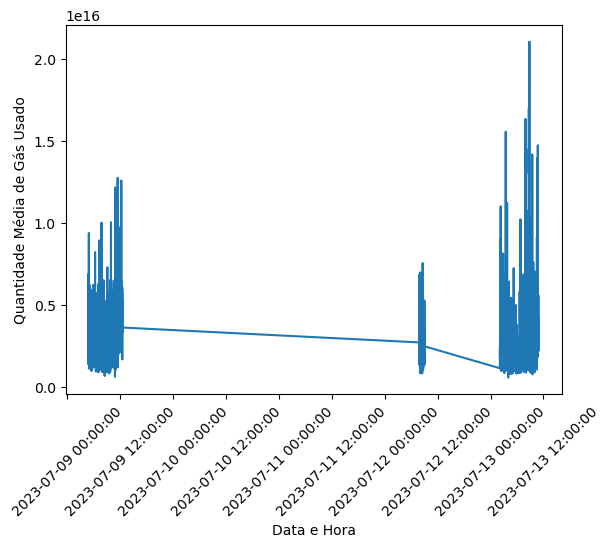

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql.functions import col, to_timestamp, expr
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Converter a coluna 'Timestamp_Transacao' para o formato 'timestamp'
combined_transaction_df = combined_transaction_df.withColumn('Timestamp_Transaction', to_timestamp(col('Timestamp_Transaction')))

# Criar a coluna Gas_Utilizado, no qual Gas_Utilizado é o preço do gás vezes o limite
combined_transaction_df = combined_transaction_df.withColumn("Transaction_Fee", expr("Gas_Price * Gas_Used"))

# Calcular a média de 'Gás_Usado' agrupada por data e hora
grouped_df = combined_transaction_df.groupBy('Timestamp_Transaction').mean('Transaction_Fee')

# Ordenar os valores pela coluna 'Timestamp_Transacao'
ordered_df = grouped_df.orderBy('Timestamp_Transaction')

# Obter os valores das colunas 'Timestamp_Transacao' e 'avg(Gás_Usado)' em listas
timestamps = ordered_df.select('Timestamp_Transaction').rdd.flatMap(lambda x: x).collect()
avg_gas_used = ordered_df.select('avg(Transaction_Fee)').rdd.flatMap(lambda x: x).collect()

# Plotar o gráfico
fig, ax = plt.subplots()
ax.plot(timestamps, avg_gas_used)

# Formatar o eixo x para exibir a data/hora
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

plt.xlabel('Data e Hora')
plt.ylabel('Quantidade Média de Gás Usado')

plt.show()

In [11]:
driver_memory = spark.conf.get("spark.driver.memory")
executor_memory = spark.conf.get("spark.executor.memory")

print("Memória alocada para o driver Spark: ", driver_memory)
print("Memória alocada para os executores Spark: ", executor_memory)

Memória alocada para o driver Spark:  4g
Memória alocada para os executores Spark:  4g
